In [1]:
import os
import csv
import json
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [2]:
# Load in stroke data from a csv
cousin_directory_path = os.path.join(os.getcwd(), '..', 'training_data')
cousin_directory_path = os.path.abspath(cousin_directory_path)

stroke_data_filename = 'normalized_strokes.csv'
csv_file_path = os.path.join(cousin_directory_path, stroke_data_filename)

The dataset has string representations for each label. We create a mapping between each unique string to a unique integer.

In [4]:
unique_labels = set()

with open(csv_file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip header
    for row in csv_reader:
        label = row[1]
        unique_labels.add(label)


sorted_labels = sorted(list(unique_labels))

label_to_index = {label: index for index, label in enumerate(sorted_labels)}
index_to_label = {index: label for label, index in label_to_index.items()}

# Save the label mappings to a JSON file
label_mapping_filename = 'label_mapping.json'
label_mapping_path = os.path.join(cousin_directory_path, label_mapping_filename)

with open(label_mapping_path, 'w') as json_file:
    json.dump(index_to_label, json_file)

Create dataset for stroke data

In [5]:
class StrokeDataset(Dataset):
    def __init__(self, csv_file, label_mapping):
        """
        Args:
            csv_file (str): Path to the csv file with stroke data.
            label_mapping (dict): Mapping from string labels to integer indices.
        """
        super().__init__()
        self.data = []
        self.labels = []
        self.label_mapping = label_mapping

        with open(csv_file, mode='r') as file:
            csv_reader = csv.reader(file)
            next(csv_reader)  # Skip header
            for row in csv_reader:
                label_str = row[1]
                stroke_points = row[2]

                # Convert stroke points from string to float tuples
                stroke_points = json.loads(stroke_points)
                self.data.append(stroke_points)
                self.labels.append(self.label_mapping[label_str])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        stroke = np.array(self.data[index], dtype=np.float32)
        label = self.labels[index]

        return stroke, label

In [6]:
class SubsetStrokeDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        stroke = np.array(self.data[index], dtype=np.float32)
        label = self.labels[index]

        return stroke, label

In [7]:
dataset = StrokeDataset(csv_file_path, label_to_index)

In [9]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_data, temp_data, train_labels, temp_labels = train_test_split(
    dataset.data, dataset.labels,
    train_size=train_size,
    random_state=42,
    stratify=dataset.labels
)

counter_temp = Counter(temp_labels)
insufficient_classes = [cls for cls, count in counter_temp.items() if count < 2]
print("Classes with fewer than 2 samples in temp_labels:", insufficient_classes)

if insufficient_classes:
    indices_to_move = [i for i, label in enumerate(temp_labels) if label in insufficient_classes]

    # Reassign these samples to the training set
    for idx in sorted(indices_to_move, reverse=True):
        train_data.append(temp_data.pop(idx))
        train_labels.append(temp_labels.pop(idx))

    print(f"Moved {len(indices_to_move)} samples to the training set to ensure all classes in temp_labels have at least 2 samples.")

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels,
    train_size=val_size / (val_size + test_size),
    random_state=42,
    stratify=temp_labels
)

train_dataset = SubsetStrokeDataset(train_data, train_labels)
val_dataset = SubsetStrokeDataset(val_data, val_labels)
test_dataset = SubsetStrokeDataset(test_data, test_labels)

print(f"Final dataset sizes:\n"
      f" - Training: {len(train_dataset)} samples\n"
      f" - Validation: {len(val_dataset)} samples\n"
      f" - Testing: {len(test_dataset)} samples")

Classes with fewer than 2 samples in temp_labels: [729, 237, 330, 845, 208, 170, 955, 286, 219, 1076, 829, 337, 154, 55, 910, 341, 673, 892, 963, 789, 805, 972, 117, 1082, 152, 272, 859, 216, 971, 228, 383, 848, 98]
Moved 33 samples to the training set to ensure all classes in temp_labels have at least 2 samples.
Final dataset sizes:
 - Training: 147350 samples
 - Validation: 31552 samples
 - Testing: 31552 samples


In [10]:
def collate_fn(batch):
    """
    Handles variable length sequences in stroke data by padding them with zeros.

    Args:
        batch (List[Tuple]): Each tuple contains (stroke, label).

    Returns:
        padded_strokes (torch.Tensor): Tensor of shape (batch_size, max_seq_length, 2).
        labels (torch.Tensor): Tensor of shape (batch_size,).
    """
    strokes, labels = zip(*batch)
    strokes = [torch.tensor(stroke, dtype=torch.float32) for stroke in strokes]

    # Pad sequences with zeros to amke sure each stroke is the same length
    padded_strokes = pad_sequence(strokes, batch_first=True, padding_value=0.0)
    labels = torch.tensor(labels, dtype=torch.long)

    return padded_strokes, labels

In [11]:
# Create dataloaders
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)

In [12]:
class StrokeLSTMClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, num_classes=10, dropout=0.3, bidirectional=True):
        """
        Args:
            input_size (int): Number of input features per time step (e.g., 2 for x and y).
            hidden_size (int): Number of features in the hidden state.
            num_layers (int): Number of recurrent layers.
            num_classes (int): Number of output classes.
            dropout (float): Dropout probability.
            bidirectional (bool): If True, becomes a bidirectional LSTM.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Padded input tensor of shape (batch_size, seq_length, input_size)

        Returns:
            out (torch.Tensor): Output logits of shape (batch_size, num_classes)
        """
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1),
                         x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1),
                         x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step
        out = out[:, -1, :]

        out = self.dropout(out)
        out = self.fc(out)
        return out

In [13]:
num_classes = len(sorted_labels)

model = StrokeLSTMClassifier(
    input_size=3,
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout=0.3,
    bidirectional=True
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:
def train(model, optimizer, scheduler, loss_fn, train_loader, val_loader, num_epochs):
    best_val_loss = float('inf')
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for strokes, labels in tqdm(train_loader, desc=f'Epoch {epoch} - Training'):
            strokes, labels = strokes.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(strokes)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * strokes.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Record average train loss and accuracy in the batch
        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for strokes, labels in tqdm(val_loader, desc=f'Epoch {epoch} - Validation'):
                strokes, labels = strokes.to(device), labels.to(device)
                outputs = model(strokes)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * strokes.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Record average val loss and accuracy in the batch
        avg_val_loss = val_loss / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(correct / total)

        scheduler.step()

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'lstm_model.pth')
            print(f'Best model saved at epoch {epoch}.')

    return train_losses, train_accuracies, val_losses, val_accuracies

In [15]:
num_epochs = 50

train_losses, train_accuracies, val_losses, val_accuracies = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)

Epoch 1 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.83it/s]


Best model saved at epoch 1.


Epoch 2 - Validation: 100%|██████████| 986/986 [00:11<00:00, 82.95it/s]


Best model saved at epoch 2.


Epoch 3 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.79it/s]


Best model saved at epoch 3.


Epoch 4 - Validation: 100%|██████████| 986/986 [00:11<00:00, 83.80it/s]


Best model saved at epoch 4.


Epoch 5 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.74it/s]


Best model saved at epoch 5.


Epoch 6 - Validation: 100%|██████████| 986/986 [00:11<00:00, 83.76it/s]


Best model saved at epoch 6.


Epoch 7 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.74it/s]


Best model saved at epoch 7.


Epoch 8 - Validation: 100%|██████████| 986/986 [00:11<00:00, 83.95it/s]


Best model saved at epoch 8.


Epoch 9 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.67it/s]


Best model saved at epoch 9.


Epoch 10 - Validation: 100%|██████████| 986/986 [00:11<00:00, 83.69it/s]


Best model saved at epoch 10.


Epoch 11 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.51it/s]


Best model saved at epoch 11.


Epoch 12 - Validation: 100%|██████████| 986/986 [00:11<00:00, 82.26it/s]


Best model saved at epoch 12.


Epoch 13 - Validation: 100%|██████████| 986/986 [00:12<00:00, 80.48it/s]


Best model saved at epoch 13.


Epoch 14 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.48it/s]


Best model saved at epoch 14.


Epoch 15 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.62it/s]


Best model saved at epoch 15.


Epoch 16 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.77it/s]


Best model saved at epoch 16.


Epoch 17 - Validation: 100%|██████████| 986/986 [00:11<00:00, 82.41it/s]


Best model saved at epoch 17.


Epoch 18 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.63it/s]


Best model saved at epoch 18.


Epoch 19 - Validation: 100%|██████████| 986/986 [00:11<00:00, 83.28it/s]


Best model saved at epoch 19.


Epoch 20 - Validation: 100%|██████████| 986/986 [00:11<00:00, 84.37it/s]


Best model saved at epoch 20.


Epoch 21 - Validation: 100%|██████████| 986/986 [00:11<00:00, 83.43it/s]


Best model saved at epoch 21.


Epoch 22 - Validation: 100%|██████████| 986/986 [00:12<00:00, 82.13it/s]


Best model saved at epoch 22.


Epoch 25 - Validation: 100%|██████████| 986/986 [00:11<00:00, 82.75it/s]


Best model saved at epoch 25.


Epoch 26 - Validation: 100%|██████████| 986/986 [00:11<00:00, 83.99it/s]


Best model saved at epoch 26.


Epoch 28 - Validation: 100%|██████████| 986/986 [00:11<00:00, 82.55it/s]


Best model saved at epoch 28.


Epoch 29 - Validation: 100%|██████████| 986/986 [00:12<00:00, 79.17it/s]


Best model saved at epoch 29.


Epoch 30 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.69it/s]


Best model saved at epoch 30.


Epoch 31 - Validation: 100%|██████████| 986/986 [00:11<00:00, 84.11it/s]


Best model saved at epoch 31.


Epoch 33 - Validation: 100%|██████████| 986/986 [00:11<00:00, 82.49it/s]


Best model saved at epoch 33.


Epoch 36 - Validation: 100%|██████████| 986/986 [00:12<00:00, 81.98it/s]


Best model saved at epoch 36.


Epoch 39 - Validation: 100%|██████████| 986/986 [00:12<00:00, 77.80it/s]


Best model saved at epoch 39.


Epoch 40 - Validation: 100%|██████████| 986/986 [00:11<00:00, 82.41it/s]


Best model saved at epoch 40.


Epoch 50 - Validation: 100%|██████████| 986/986 [00:12<00:00, 82.14it/s]


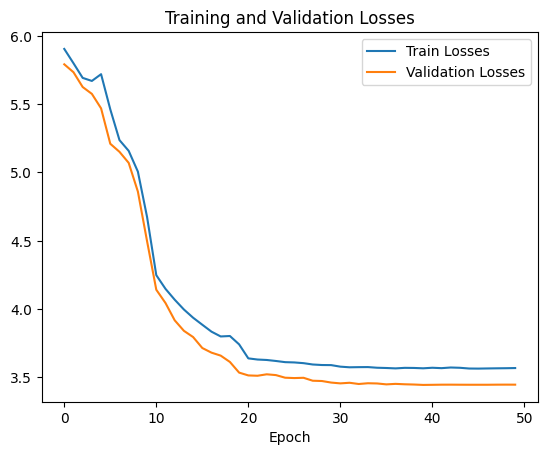

In [19]:
plt.plot(train_losses, label="Train Losses")
plt.plot(val_losses, label="Validation Losses")
plt.xlabel("Epoch")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

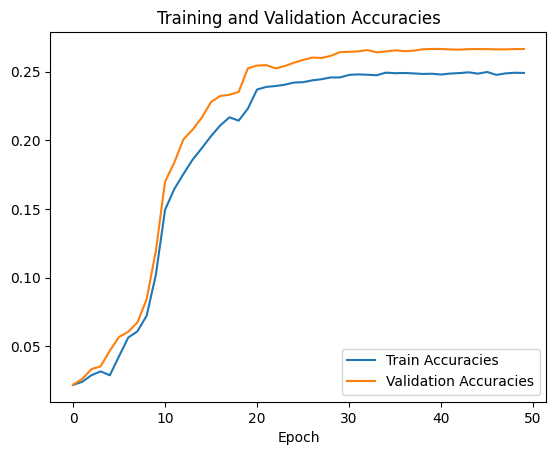

In [20]:
plt.plot(train_accuracies, label="Train Accuracies")
plt.plot(val_accuracies, label="Validation Accuracies")
plt.xlabel("Epoch")
plt.title("Training and Validation Accuracies")
plt.legend()
plt.show()

In [21]:
def test_model(loss_fn, model_path='lstm_model.pth'):
    # Import saved model
    num_classes = len(sorted_labels)
    model = StrokeLSTMClassifier(
        input_size=3,
        hidden_size=128,
        num_layers=2,
        num_classes=num_classes,
        dropout=0.3,
        bidirectional=True
    ).to(device)

    model.load_state_dict(torch.load(model_path))

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for strokes, labels in tqdm(test_loader, desc='Testing'):
            strokes, labels = strokes.to(device), labels.to(device)
            outputs = model(strokes)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item() * strokes.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / total
    test_accuracy = correct / total

    return avg_test_loss, test_accuracy

In [22]:
avg_test_loss, test_accuracy = test_model(loss_fn=loss_fn, model_path='lstm_model.pth')
print(f"Average Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {test_accuracy}")

<ipython-input-21-e6c943cdcf65>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 986/986 [00:13<00:0

Average Test Loss: 3.5935640020738027
Test Accuracy: 0.2467355476673428
